<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/I_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),])
# transform = transforms.Compose([transforms.RandomResizedCrop((32,32), scale=(.3,1.)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 64 # 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader) # get some random training images
# images, labels = next(dataiter)
# print(images.shape) # [batch, 3, 32, 32]
# imshow(torchvision.utils.make_grid(images))


100%|██████████| 170M/170M [00:18<00:00, 9.12MB/s]


In [2]:
# @title RoPE2D & RotEmb
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def RoPE(dim, seq_len=512, base=10000):
    theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
    pos = torch.arange(seq_len).unsqueeze(-1)
    angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
    rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, seq_len, dim // 2, 2] -> [1, seq_len, dim]
    return rot_emb

# class RoPE(nn.Module): # Rotary Positional Embeddings
#     def __init__(self, dim, seq_len=512, base=10000):
#         super().__init__()
#         self.dim, self.base = dim, base
#         theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
#         pos = torch.arange(seq_len).unsqueeze(-1)
#         angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
#         self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, seq_len, dim // 2, 2] -> [1, seq_len, dim]

#     def forward(self, x): # [batch, T, dim] / [batch, T, n_heads, d_head]
#         seq_len = x.size(1)
#         if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
#         # print('rope fwd', x.shape, self.rot_emb.shape)
#         if x.dim()==4: return x * self.rot_emb[:,:seq_len].unsqueeze(2)
#         return x * self.rot_emb[:,:seq_len]


def RoPE2D(dim=16, h=8, w=8, base=10000):
    # theta = 1. / (base ** (torch.arange(0, dim, step=4) / dim))
    # theta = 1. / (base**torch.linspace(0,1,dim//4)).unsqueeze(0)
    theta = 1. / (base**torch.linspace(0,1,dim//2)).unsqueeze(0)
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
    y, x = (y.reshape(-1,1) * theta).unsqueeze(-1), (x.reshape(-1,1) * theta).unsqueeze(-1) # [h*w,1]*[1,dim//4] = [h*w, dim//4, 1]
    # rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).flatten(-2) # [h*w, dim//4 ,4] -> [h*w, dim]
    # rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1)#.reshape(dim, h, w).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
    rot_emb = torch.cat([x.sin(), y.sin()], dim=-1).flatten(-2).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
    # rot_emb = torch.cat([x.cos(), y.cos()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
    return rot_emb



# class RoPE2D(nn.Module): # Rotary Positional Embeddings
#     def __init__(self, dim, h=224, w=224, base=10000):
#         super().__init__()
#         self.dim, self.h, self.w = dim, h, w
#         # # theta = 1. / (base ** (torch.arange(0, dim, step=4) / dim))
#         # theta = 1. / (base**torch.linspace(0,1,dim//4)).unsqueeze(0)
#         theta = 1. / (base**torch.linspace(0,1,dim//2)).unsqueeze(0)
#         y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
#         y, x = (y.reshape(-1,1) * theta).unsqueeze(-1), (x.reshape(-1,1) * theta).unsqueeze(-1) # [h*w,1]*[1,dim//4] = [h*w, dim//4, 1]
#         # # self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).flatten(-2) # [h*w, dim//4 ,4] -> [h*w, dim]
#         # self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
#         self.rot_emb = torch.cat([x.sin(), y.sin()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
#         # self.rot_emb = torch.cat([x.cos(), y.cos()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]

#     def forward(self, img): #
#         # batch, dim, h, w = img.shape
#         # print(img.shape)
#         hw = img.shape[1] # [b, hw, dim] / [b, hw, n_heads, d_head]
#         h=w=int(hw**.5)
#         if self.h < h or self.w < w: self.__init__(self.dim, h, w)
#         # print(self.rot_emb.shape)
#         # rot_emb = self.rot_emb[:, :h, :w].unsqueeze(0) # [1, h, w, dim]
#         rot_emb = self.rot_emb[:h, :w] # [h, w, dim]
#         # return img * rot_emb.flatten(end_dim=1).unsqueeze(0) # [b, hw, dim] * [1, hw, dim]
#         return img * rot_emb.flatten(end_dim=1)[None,:,None,:] # [b, hw, n_heads, d_head] * [1, hw, 1, dim]
#         # return img * self.rot_emb

class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))
        # self.theta = top / (base ** torch.linspace(0, 1, dim//2, device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]


In [3]:
# @title AttentionBlock
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.dim, self.n_heads = dim, n_heads
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        # self.lin = nn.Linear(dim, dim)
        self.lin = zero_module(nn.Linear(dim, dim))
        # self.rope = RoPE(d_head, seq_len=512, base=10000)
        # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        self.scale = d_head**-.5

    def forward(self, x): # [b,t,d]
        q,k,v = self.qkv(x).unflatten(-1, (self.n_heads,-1)).transpose(1,2).chunk(3, dim=-1) # [b, t, n_heads, d_head] -> [b, n_heads, t, d_head]
        # q, k = self.rope(q), self.rope(k)
        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t, d_head]
        # print('SelfAttn', x.shape)
        x = x.transpose(1,2).flatten(2)
        return self.lin(x)

class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, mult=4, drop=0.):
        super().__init__()
        self.d_model = d_model
        # self.norm = nn.RMSNorm(d_model, elementwise_affine=False) # LayerNorm RMSNorm
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.drop = nn.Dropout(drop)
        self.attn = SelfAttn(d_model, n_heads)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Dropout(drop), act, nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), nn.Dropout(drop), nn.Linear(ff_dim, d_model)
            nn.RMSNorm(ff_dim), nn.Dropout(drop), act, zero_module(nn.Linear(ff_dim, d_model))
            # nn.RMSNorm(d_model), act, nn.Dropout(drop), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(drop), nn.Linear(ff_dim, d_model)
            # nn.Linear(d_model, ff_dim), nn.GELU(), nn.Dropout(drop),
            # nn.Linear(ff_dim, d_model), nn.Dropout(drop),
        )

    def forward(self, x): # [batch, seq_len, d_model]
        # print('attnblk fwd',x.shape)
        x = x + self.drop(self.attn(self.norm1(x)))
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(self.norm2(x)))
        return x


In [4]:
# @title masks
import torch

def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask


def multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_aspect = torch.rand(1) * (aspect_ratio[1] - aspect_ratio[0]) + aspect_ratio[0] # in (min_s, max_s) # all blocks same size
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    h = (mask_scale/mask_aspect)**.5# h*(h*aspect) = scale
    w = h * mask_aspect
    h_pos, w_pos = torch.rand(M)*(1-w), torch.rand(M)*(1-h) # in (0, 1 - mask_len)
    h_len, h_pos = (h*hw[0]).int(), h_pos*hw[0]
    w_len, w_pos = (w*hw[1]).int(), w_pos*hw[1]
    h_ind, w_ind = torch.arange(hw[0]).unsqueeze(0), torch.arange(hw[1]).unsqueeze(0) # [1, seq]
    h_mask = (h_ind>=h_pos.unsqueeze(-1)) & (h_ind<(h_pos+h_len).unsqueeze(-1)) # [M, seq]
    w_mask = (w_ind>=w_pos.unsqueeze(-1)) & (w_ind<(w_pos+w_len).unsqueeze(-1)) # [M, seq]
    target_mask = h_mask.unsqueeze(-1) & w_mask.unsqueeze(-2) # [M, seq, seq]
    return target_mask

# https://arxiv.org/pdf/2210.07224
def randpatch(seq, mask_size=8, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    # mask = torch.rand(seq//mask_size)<gamma
    length = seq//mask_size
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    idx = torch.randperm(length)[:int(length*g)]
    mask = torch.zeros(length, dtype=bool)
    mask[idx] = True
    mask = mask.repeat_interleave(mask_size, dim=-1)
    return mask # [seq] , True -> mask


import torch
def apply_masks(x, mask): # [b,t,d], [mask_size] # https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
    mask_keep = mask.unsqueeze(-1).repeat(x.size(0), 1, x.size(-1)) # [batch,T,dim]
    return torch.gather(x, dim=1, index=mask_keep) # [batch,mask_size,dim]



In [9]:
# @title simplex
!pip install -q opensimplex
import opensimplex
import numpy as np


def simplexmask(hw=(8,8), scale=(.15,.2)):
    ix = iy = np.linspace(0, 1, num=8)
    ix, iy = ix+np.random.randint(1e10), iy+np.random.randint(1e10)
    y=opensimplex.noise2array(ix, iy)
    y = torch.from_numpy(y)
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    yy = y.flatten().sort()[0][int(hw[0]*hw[1]*mask_scale)]
    mask = (y<=yy.item())
    return mask # T/F [h,w]

# mask = simplexmask(hw=(8,8), scale=(.6,.8))
# mask = ~simplexmask(hw=(8,8), scale=(.85,1))

# from matplotlib import pyplot as plt
# # plt.pcolormesh(y)
# plt.pcolormesh(mask)
# plt.show()

# print(mask)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 23.7 MB/s eta 0:00:00


In [5]:
# @title TransformerModel/Predictor
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'


class TransformerPredictor(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        # self.pos_emb = nn.Parameter(torch.randn(1, 8*8, d_model)*0.02)
        # self.pos_emb = nn.Parameter(RoPE2D(dim=d_model, h=8, w=8, base=1000), requires_grad=False)
        self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=8*8, base=10000), requires_grad=False)

        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.randn(1,1,d_model)*0.02) # randn zeros
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, x, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = x.shape
        # x = x * self.pos_enc(context_indices)
        # print("Trans pred",x.shape, self.pos_emb.shape)
        # print("Trans pred",x.shape, self.pos_emb[:,context_indices].shape)
        x = x + self.pos_emb[:,context_indices]

        # pred_tokens = self.cls * self.pos_enc(trg_indices) # [M, num_trg_toks, d_model]
        # pred_tokens = self.cls + self.positional_emb[0,trg_indices]
        pred_tokens = self.cls + self.pos_emb[:,trg_indices]
        # print("Trans pred",pred_tokens.shape, self.cls.shape, self.positional_emb[:,trg_indices].shape)
        pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch, num_trg_toks, d_model]
        # print(pred_tokens.requires_grad)
        # print("pred fwd", x.shape, pred_tokens.shape)
        x = torch.cat([x, pred_tokens], dim=1) # [batch, seq_len+num_trg_toks, d_model]
        out = self.transformer(x)

        out = self.norm(out)
        out = out[:,seq:] # [batch, num_trg_toks, d_model]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


class TransformerModel(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, patch_size, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0.):
        super().__init__()
        # patch_size=4
        self.embed = nn.Sequential(
            nn.Conv2d(in_dim, d_model, patch_size, patch_size), # like patch
            # nn.Conv2d(in_dim, d_model, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # nn.Conv2d(in_dim, d_model, 3, 2, 3//2, bias=False), nn.BatchNorm2d(d_model), nn.ReLU(),
            )
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        # self.pos_emb = nn.Parameter(torch.randn(1, 8*8, d_model)*0.02)
        # self.pos_emb = nn.Parameter(RoPE2D(dim=d_model, h=8, w=8, base=1000), requires_grad=False)
        self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=8*8, base=10000), requires_grad=False)
        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, x, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        x = self.embed(x).flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c] # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        # x = self.pos_enc(x)
        # print("TransformerModel",x.shape, self.pos_emb.shape)
        x = x + self.pos_emb
        if context_indices != None: x = x[:,context_indices]

        x = self.transformer(x)
        out = self.norm(x)
        if self.lin: out = self.lin(out)
        return out


batch, seq_len, d_model = 4,1024,32
in_dim = 3
patch_size = 4
model = TransformerModel(patch_size, in_dim, d_model, n_heads=4, nlayers=4, drop=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x = torch.rand((batch, in_dim, 32, 32), device=device)
# x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
print(out.shape)
# # # print(out)
# model = TransformerPredictor(in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1).to(device)
# out = model(out)
# print(out.shape)



52672
torch.Size([4, 64, 32])


In [13]:
# @title IJEPA
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

class IJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, n_heads=4):
        super().__init__()
        if out_dim is None: out_dim = d_model
        self.patch_size = 4
        self.student = TransformerModel(self.patch_size, in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=0.)
        # self.predicter = TransformerPredictor(out_dim, d_model//2, out_dim, n_heads=n_heads, nlayers=nlayers//2, drop=0.)
        self.predicter = TransformerPredictor(out_dim, 3*d_model//8, out_dim, n_heads=4, nlayers=1, drop=0.)
        import copy
        # self.teacher = copy.deepcopy(self.student)
        self.teacher = TransformerModel(self.patch_size, in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=0.)
        self.teacher.requires_grad_(False)
        # self.classifier = nn.Linear(out_dim, 18) # 10 18

    def loss(self, x): # [batch, T, 3]
        # batch, seq, dim = x.shape
        b,c,h,w = x.shape
        # # print(x.shape)
        # target_mask = multiblock(seq//self.patch_size, min_s=0.15, max_s=0.2, M=4).any(0) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
        # # target_mask = multiblock(seq//self.patch_size, min_s=0.2, max_s=0.3, M=4).any(0) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
        # # target_mask = randpatch(seq//self.patch_size, mask_size=8, gamma=.9) # 8.9 [seq]
        # context_mask = ~multiblock(seq//self.patch_size, min_s=0.85, max_s=1., M=1)|target_mask # og .85,1.M1 # [1, seq], True->Mask

        # target_mask = multiblock2d((8,8), scale=(.2,.3), aspect_ratio=(.75,1.5), M=4).any(0).unsqueeze(0) # [1,h,w], True->Mask
        target_mask = simplexmask(hw=(8,8), scale=(.7,.8)).unsqueeze(0) # .6.8
        context_mask = ~multiblock2d((8,8), scale=(.85,1), aspect_ratio=(1,1), M=1)|target_mask # [1,h,w], True->Mask
        # context_mask = torch.zeros((1,8,8), dtype=bool)|target_mask # [1,h,w], True->Mask
        # # context_mask = ~simplexmask(hw=(8,8), scale=(.85,1)).unsqueeze(0)|target_mask # [1,h,w]

        # imshow(target_mask)
        # imshow(context_mask)

        target_mask, context_mask = target_mask.flatten(), context_mask.flatten() # [8*8]
        target_mask, context_mask = target_mask.to(device), context_mask.to(device)
        # print(target_mask.shape, context_mask.shape)
        # print(target_mask)
        # print(context_mask)

        context_indices = (~context_mask).nonzero().squeeze(-1) # int idx [num_context_toks] , idx of context not masked
        # print('ijepa loss context_indices',context_indices)
        # print('ijepa loss x',x.shape)
        sx = self.student(x, context_indices=context_indices) # [batch, num_context_toks, out_dim]
        # print('ijepa loss sx',sx.shape)

        trg_indices = target_mask.nonzero().squeeze(-1) # int idx [num_trg_toks] , idx of targets that are masked
        # print(trg_indices.shape)
        sy_ = self.predicter(sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]
        sy_ = F.layer_norm(sy_, (sy_.size(-1),))
        with torch.no_grad():
            sy = self.teacher(x.detach()) # [batch, num_trg_toks, out_dim]
            # print(sy.shape, sy[0,:,:6])
            sy = sy[:,trg_indices] # nan bec len(trg_ind)==0 # print('loss sy',torch.isnan(sy).any())
            # print(sy.shape, sy[0,:,:6])
            # print(trg_indices)
            sy = F.layer_norm(sy, (sy.size(-1),))
        loss = F.mse_loss(sy, sy_)
        return loss

    def forward(self, x): # [batch, T, 3]
        sx = self.student(x)
        out = sx.mean(dim=1)
        return out

    # def classify(self, x): # [batch, T, 3]
    #     sx = self.forward(x)
    #     out = self.classifier(sx)
    #     return out

# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

ijepa = IJEPA(in_dim=3, d_model=32, out_dim=16, nlayers=4, n_heads=4).to(device)#.to(torch.float)
# ijepa = IJEPA(in_dim=3, d_model=1024, out_dim=16, nlayers=12, d_head=16).to(device)#.to(torch.float)
# optim = torch.optim.AdamW(ijepa.parameters(), lr=1e-3) # 1e-3?
optim = torch.optim.AdamW([{'params': ijepa.student.parameters()},
    # {'params': ijepa.predicter.parameters(), 'lr': 1e-2}], lr=1e-3)#, weight_decay=0) default 1e-2
    {'params': ijepa.predicter.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2, 5e-2

# https://github.com/facebookresearch/ijepa/blob/main/configs/in1k_vith14_ep300.yaml
# d_model 1024,384
# depth 12,6/12
# wd 5e-2 - 4e-1
# adamw 1e-4 - 1e-3 - 1e-6
# ema 0.996-1

print(sum(p.numel() for p in ijepa.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in ijepa.parameters())) # 27584
# print(sum(p.numel() for p in ijepa.predicter.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in ijepa.student.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in ijepa.teacher.transformer_encoder.parameters() if p.requires_grad)) # 27584
# d_model^2 * nlayers

x = torch.rand((2,3,32,32), device=device)
out = ijepa.loss(x)
print(out.shape)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(16).to(device)
# classifier = Classifier(16, 18).to(device)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)
# optim = torch.optim.AdamW([{'params': ijepa.parameters()}, {'params': classifier.parameters(), 'lr': 1e-3}], lr=1e-3)



55544
torch.Size([])


In [ ]:
# @title TransformerVICReg
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerVICReg(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, drop=0):
        super().__init__()
        act = nn.GELU()
        patch_size=4
        self.embed = nn.Sequential(
            # nn.Linear(in_dim, d_model), act
            # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            # nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            # nn.Conv1d(d_model, d_model,3,2,3//2),
            nn.Conv2d(in_dim, d_model, patch_size, patch_size), # patch
            )
        self.pos_enc = RoPE(d_model, seq_len=200, base=10000)
        # self.pos_emb = nn.Parameter(torch.randn(1, 8*8, d_model))
        # self.pos_emb = nn.Parameter(RoPE2D(dim=d_model, h=8, w=8, base=10000).unsqueeze(0), requires_grad=False)

        self.transformer = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        # out_dim = out_dim or d_model
        self.lin = nn.Linear(d_model, out_dim)
        self.attn_pool = nn.Linear(d_model, 1, bias=False)

        dim_v = d_model * 4
        self.exp = nn.Sequential(
            nn.Linear(out_dim, dim_v), act,
            nn.Linear(dim_v, dim_v), act,
            nn.Linear(dim_v, dim_v, bias=False),
            )

    def forward(self, x): # [b,t,d] / [b,c,h,w]
        x = self.embed(x).flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c]
        # x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [b,t,d]
        x = self.pos_enc(x)
        # x = x + self.pos_emb

        x = self.transformer(x)

        attn = self.attn_pool(x).squeeze(-1) # [batch, seq] # seq_pool
        out = (torch.softmax(attn, dim=-1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, seq] @ [batch, seq, dim] -> [batch, dim]
        out = self.lin(out)
        return out # [seq_len, batch, ntoken]

    def expand(self, x):
        sx = self.forward(x)
        vx = self.exp(sx)
        return vx

batch, seq_len, d_model = 4,3500,512
in_dim, out_dim=3,16
model = TransformerVICReg(in_dim, d_model, out_dim, d_head=4, nlayers=2, drop=0.).to(device)
# x =  torch.rand((batch, seq_len, in_dim), device=device)
x =  torch.rand((batch, in_dim, 32,32), device=device)
out = model(x)
print(out.shape)


torch.Size([4, 16])


In [ ]:
# @title Violet
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class Violet(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, d_head=4):
        super().__init__()
        out_dim = out_dim or d_model
        self.student = TransformerVICReg(in_dim, d_model, out_dim=out_dim, d_head=d_head, nlayers=nlayers, drop=0.)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)

        # vicreg
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν

        self.classifier = nn.Linear(out_dim, 18) # 10 18

    def loss(self, x): # [batch, T, 3]c/ [b,c,h,w]
        # print(x.shape)
        vx = self.student.expand(x) # [batch, num_context_toks, out_dim]
        with torch.no_grad(): vy = self.teacher.expand(x.detach()) # [batch, num_trg_toks, out_dim]
        loss = self.vicreg(vx, vy)
        return loss

    def forward(self, x): # [batch, T, 3]
        return self.student(x)

    def classify(self, x): # [batch, T, 3]
        sx = self.forward(x)
        out = self.classifier(sx)
        return out


    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size, num_features = x.shape

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = self.sim_coeff * repr_loss + self.std_coeff * std_loss + self.cov_coeff * cov_loss
        print("in vicreg ",self.sim_coeff * repr_loss.item() , self.std_coeff * std_loss.item() , self.cov_coeff * cov_loss.item())
        # return loss
        return repr_loss, std_loss, cov_loss


violet = Violet(in_dim=3, d_model=32, out_dim=16, nlayers=2, d_head=4).to(device)
voptim = torch.optim.AdamW(violet.parameters(), lr=1e-3) # 1e-3?
# voptim = torch.optim.AdamW([{'params': violet.student.transformer.parameters()},
#     {'params': violet.student.exp.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2
print(sum(p.numel() for p in violet.parameters() if p.requires_grad)) # 27584

# x = torch.rand((2,1000,3), device=device)
x = torch.rand((2,3,32,32), device=device)
# x = torch.rand((2,1,16), device=device)
loss = violet.loss(x)
# print(out.shape)
print(loss)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(16).to(device)
# classifier = Classifier(16, 18).to(device)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)



62850
in vicreg  0.00019920778413506923 24.74469393491745 4.793645480560826e-09
(tensor(7.9683e-06, grad_fn=<MseLossBackward0>), tensor(0.9898, grad_fn=<AddBackward0>), tensor(4.7936e-09, grad_fn=<AddBackward0>))


In [ ]:
for name, param in ijepa.named_parameters():
    if param.requires_grad:
        print(name, param)

In [ ]:
# @title strain ctrain test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

def strain(model, dataloader, optim, scheduler=None): # train function with automatic mixed precision
    model.train()
    for i, (x, _) in enumerate(dataloader):
        x = x.to(device)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            loss = model.loss(x)

            # repr_loss, std_loss, cov_loss = model.loss(x)
            # loss = model.sim_coeff * repr_loss + model.std_coeff * std_loss + model.cov_coeff * cov_loss

        optim.zero_grad()
        scaler.scale(loss).backward()
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # 0.5

        scaler.step(optim)
        scaler.update()

        with torch.no_grad():
            m=0.999 # 0.99 m = next(momentum_scheduler)
            norms=[]
            for param_q, param_k in zip(model.student.parameters(), model.teacher.parameters()):
                param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # try: wandb.log({"loss": loss.item(), "repr/I": repr_loss.item(), "std/V": std_loss.item(), "cov/C": cov_loss.item()})
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


def ctrain(model, classifier, dataloader, coptim, scheduler=None): # train function with automatic mixed precision
    model.eval()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device) # [batch, ]
        # x = x.flatten(2).transpose(-2,-1).to(torch.bfloat16)
        # x, y = x[...,1:].to(device).to(torch.bfloat16), y[1].to(device) # [batch, ] # (id, activity)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            with torch.no_grad():
                sx = model(x).detach()
            # print(sx[0][0])
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)

        coptim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(coptim)
        scaler.update()
        print("classify",loss.item())
        try: wandb.log({"closs": loss.item()})
        except NameError: pass
        if i>=10: break


def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device) # [batch, ]
        # x = x.flatten(2).transpose(-2,-1)#.to(torch.bfloat16)
        # x, y = x[...,1:].to(device).to(torch.float), y[1].to(device) # [batch, ] # (id, activity)
        with torch.no_grad():
            sx = model(x)
            y_ = classifier(sx)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y)})
        except NameError: pass
        if i>=10: break


# for i in range(1):
for i in range(500):
    print(i)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    # np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    # train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # # batch_size = 64 #512
    # train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    # test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    strain(ijepa, train_loader, optim)
    ctrain(ijepa, classifier, train_loader, coptim)
    test(ijepa, classifier, test_loader)

    # strain(violet, train_loader, voptim)
    # ctrain(violet, classifier, train_loader, coptim)
    # test(violet, classifier, test_loader)



Streaming output truncated to the last 5000 lines.
strain 0.36385244131088257
strain 0.337560772895813
strain 0.31995251774787903
strain 0.4488065242767334
strain 0.4592253267765045
strain 0.37776777148246765
strain 0.413584440946579
classify 1.97503662109375
classify 2.0474853515625
classify 1.91357421875
classify 1.9669189453125
classify 2.072021484375
classify 2.032958984375
classify 1.95025634765625
classify 1.98876953125
classify 1.7940673828125
classify 1.8330078125
classify 1.8641357421875
0.3125
0.203125
0.25
0.3125
0.171875
0.234375
0.25
0.265625
0.28125
0.390625
0.25
335
strain 0.3256820738315582
strain 0.43757757544517517
strain 0.251610666513443
strain 0.27669206261634827
strain 0.2922835350036621
strain 0.4215180277824402
strain 0.4378739893436432
strain 0.28676918148994446
strain 0.3654462397098541
strain 0.3969525098800659
strain 0.3485243618488312
strain 0.29085883498191833
strain 0.38598281145095825
strain 0.37995612621307373
strain 0.28794610500335693
strain 0.4151855

In [14]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="ijepa", config={"model": "res18",})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


closs,▇█▆▆▆▆▄▄▅▃▅▄▄▄▃▄▃▃▃▃▃▄▃▂▃▂▃▂▃▁▄▁▂▂▂▃▁▃▃▃
correct,▂▁▆▅▅▄▇▂▄▆▅▄▅▄▄█▄▅▅▄▅▅▅▅▇▅▅▅▆▇▇▄▇▇▅▅▇▆█▄
loss,▁▁▁▁▁▂▁▁▃▁▂▂▁▁▄▃▂▄▂▂▄▃▃▂▄▄▄▄▄▅▄▅▅▇▄█▆▄▄█
closs,1.99219
correct,0.15625
loss,0.26535


In [ ]:

# @title supervised train test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

# def strain(model, dataloader, optim, scheduler=None):
def strain(model, classifier, dataloader, optim, coptim, scheduler=None):
    model.train()
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        y = y.to(device)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            # y_ = model.classify(x)
            sx = model(x)
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)

        optim.zero_grad()
        # print(loss)
        scaler.scale(loss).backward()

        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 10) # 0.5

        scaler.step(optim)
        scaler.update()

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in ijepa.student.cls: print(param.data)
        # for param in ijepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


# def test(model, dataloader):
def test(model, classifier, dataloader):
    model.eval()
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device) # [batch, ]
        # .to(torch.bfloat16)

        with torch.no_grad():
            # y_ = model.classify(x)
            sx = model(x)
            y_ = classifier(sx)
        loss = F.cross_entropy(y_, y)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y), "closs": loss.item()})
        except NameError: pass
        if i>=10: break


for i in range(1000):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    # train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # # batch_size = 64 #512
    # train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    # test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    # strain(ijepa, train_loader, optim)
    strain(ijepa, classifier, train_loader, optim, coptim)
    test(ijepa, classifier, test_loader)

    # strain(violet, train_loader, voptim)
    # test(violet, test_loader)


## drawer

torch.Size([1, 3, 8, 8])
torch.Size([1, 8, 8]) torch.Size([1, 8, 8])


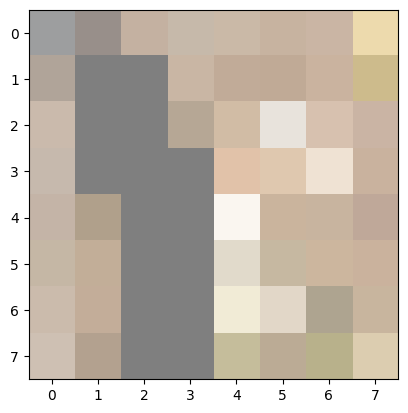

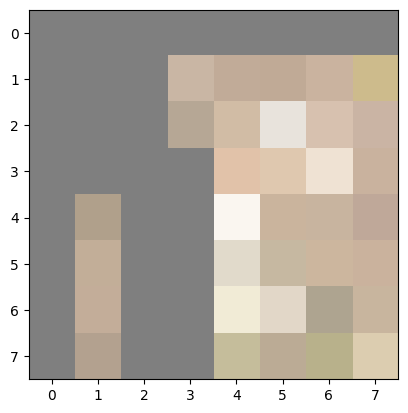

In [ ]:


# @title test multiblock params
import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_data)
img,y = next(dataiter)
img = img.unsqueeze(0)
img = F.interpolate(img, (8,8))
b,c,h,w = img.shape
# img = img.flatten(2).transpose(-2,-1).to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
print(img.shape)
# batch, seq,_ = img.shape


# # target_mask = randpatch(seq, mask_size=8, gamma=.9) # 8.9 [seq]
# target_mask = multiblock(seq, min_s=0.2, max_s=0.3, M=4).any(0) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
# target_mask = multiblock(seq, min_s=0.2, max_s=0.3, M=4).any(0)

target_mask = multiblock2d((8,8), M=4).any(0).unsqueeze(0)


# context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask # [1, seq], True->Mask
context_mask = ~multiblock2d((8,8), scale=(.85,.85), aspect_ratio=(.9,1.1), M=1)|target_mask # [1, seq], True->Mask

# print(target_mask, context_mask)

print(target_mask.shape, context_mask.shape)
# target_img, context_img = img*target_mask.unsqueeze(-1), img*context_mask.unsqueeze(-1)
# target_img, context_img = img*~target_mask.unsqueeze(-1), img*~context_mask.unsqueeze(-1)
target_img, context_img = img*~target_mask.unsqueeze(0), img*~context_mask.unsqueeze(0)
# print(target_img.shape, context_img.shape)
target_img, context_img = target_img.transpose(-2,-1).reshape(b,c,h,w), context_img.transpose(-2,-1).reshape(b,c,h,w)
target_img, context_img = target_img.float(), context_img.float()

# imshow(out.detach().cpu())
imshow(target_img[0])
imshow(context_img[0])



In [ ]:
# @title ViT me more
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

# class LayerNorm2d(nn.LayerNorm):
class LayerNorm2d(nn.RMSNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        self.lin = nn.Linear(d_model, d_model)
        # self.lin = zero_module(nn.Linear(d_model, d_model))
        # self.lin = nn.Sequential(nn.Dropout(dropout), zero_module(nn.Linear(d_model, d_model)))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).unflatten(-1, (self.n_heads, self.d_head)).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).unflatten(-1, (self.n_heads, self.d_head)).transpose(1, 2)
        K, V = self.kv(cond).unflatten(-1, (self.n_heads, 2*self.d_head)).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V

# https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py#L1855


class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, mult=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0) # 16448
        # self.self = Pooling()
        act = nn.GELU() # ReLU GELU
        # self.ff = nn.Sequential(
        #     *[nn.BatchNorm2d(d_model), act, SeparableConv2d(d_model, d_model),]*3
        #     )
        # self.ff = ResBlock(d_model) # 74112
        # self.ff = UIB(d_model, mult=4) # uib m4 36992, m2 18944
        ff_dim=d_model*mult
        self.ff = nn.Sequential(
            # nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, ff_dim), act, # ReLU GELU
            # nn.RMSNorm(d_model), nn.Dropout(dropout), zero_module(nn.Linear(ff_dim, d_model))
            nn.RMSNorm(d_model), act, nn.Dropout(dropout), nn.Linear(d_model, ff_dim),
            nn.RMSNorm(ff_dim), act, nn.Dropout(dropout), zero_module(nn.Linear(ff_dim, d_model))
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        bchw = x.shape
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # print('attnblk fwd',x.shape)

        # if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.self(self.norm(x)))
        # x = x.transpose(1,2).reshape(*bchw)
        x = x + self.ff(x)
        # x = self.ff(x)
        # x = x + self.drop(self.norm2(self.ff(x)))
        return x


import torch
# def apply_masks(x, masks): # [b,t,d], [M,mask_size] # https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
#     all_x = []
#     for m in masks: # [1,T]
#         mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [1,T,dim]
#         all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
#     return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]

def apply_masks(x, mask): # [b,t,d], [mask_size] # https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
    mask_keep = mask.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [1,T,dim]
    # return torch.cat(torch.gather(x, dim=1, index=mask_keep), dim=0)  # [M*batch,mask_size,dim]
    return torch.gather(x, dim=1, index=mask_keep) # [M*batch,mask_size,dim]


class TransformerPredictor(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        # self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, d_model)) # positional_embedding == 'learnable'
        # self.positional_emb = nn.Parameter(torch.zeros(1, dim, 8,8))
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.zeros(1,1,d_model)) # randn zeros
        nn.init.trunc_normal_(self.cls, std=.02)
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model)
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, x, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = x.shape
        # x = x * self.pos_encoder(context_indices)
        x = x + self.positional_emb[:,context_indices]
        # x = apply_masks(x, [context_indices])

        # pred_tokens = self.cls * self.pos_encoder(trg_indices) # [M, num_trg_toks, d_model]
        pred_tokens = self.cls + self.positional_emb[0,trg_indices]
        print(self.cls.shape, self.positional_emb[0,trg_indices].shape, trg_indices.shape)
        pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch*M, num_trg_toks, d_model]
        # print(pred_tokens.requires_grad)
        print("pred fwd", x.shape, pred_tokens.shape)
        # x = x.repeat_interleave(trg_indices.shape[0], dim=0) # [batch, seq_len, d_model] -> [batch*M, seq_len, d_model]
        x = torch.cat([x, pred_tokens], dim=1) # [batch*M, seq_len+num_trg_toks, d_model]

        # x = x.transpose(1,2).unflatten(-1, (8,8))#.reshape(*bchw)
        out = self.transformer_encoder(x) # float [seq_len, batch_size, d_model]
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]

        out = self.norm(out)
        out = out[:,seq:] # [batch*M, num_trg_toks, d_model]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


class TransformerModel(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        self.embed = nn.Sequential(
            # # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(2,2), #nn.MaxPool1d(3, 2, 3//2),
            # # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.Conv1d(d_model, d_model,3,2,3//2)
            # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            # nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            # nn.Conv1d(d_model, d_model,3,2,3//2),
            # # nn.Conv1d(in_dim, d_model,2,2,0), # like patch
            nn.Conv2d(in_dim, d_model, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            )
        # self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, d_model)) # positional_embedding == 'learnable'
        # self.positional_emb = nn.Parameter(torch.zeros(1, dim, 8,8)) # positional_embedding == 'learnable'
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model)
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, x, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        x = self.embed(x)
        # bchw = x.shape
        x = x.flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c] # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]

        # x = self.pos_encoder(x)
        # x = x * self.pos_encoder(torch.arange(seq, device=device)).unsqueeze(0)
        # print(x.shape, self.positional_emb.shape)
        x = x + self.positional_emb
        if context_indices != None:
            # x = apply_masks(x, [context_indices])
            x = apply_masks(x, context_indices)


        # x = x.transpose(1,2).reshape(*bchw)
        x = self.transformer_encoder(x) # float [seq_len, batch_size, d_model]
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        out = self.norm(x)
        if self.lin: out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]



# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# norm,act,conv < conv,norm,act
# 2*s1 < uib < resblock
# gatedadaln 3 < 2 = 1 < ffmult4 = 2*gatedadaln
# MaxPool2d(2,2) < MaxPool2d(3,2,3//2)


# dim = 64
# dim_head = 8
# heads = dim // dim_head
# num_classes = 10
# # model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
# model = SimpleViT(in_dim=3, out_dim=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
# optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# # print(images.shape) # [batch, 3, 32, 32]
# logits = model(x)
# print(logits.shape)
# # print(logits[0])
# # print(logits[0].argmax(1))
# pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = pred_probab.argmax(1)
# # print(f"Predicted class: {y_pred}")


batch, seq_len, d_model = 4,1024,16
in_dim = 3
model = TransformerModel(in_dim, d_model, d_head=4, nlayers=2, dropout=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x = torch.rand((batch, in_dim, 32, 32), device=device)
# x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
print(out.shape)
# # # print(out)
# model = TransformerPredictor(in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1).to(device)
# out = model(out)
# print(out.shape)



9920
torch.Size([4, 64, 16])


In [ ]:
# @title simplex
!pip install opensimplex
from opensimplex import OpenSimplex

seed=0
noise = OpenSimplex(seed)  # Replace 'seed' with your starting value
noise_scale = 10  # Adjust for desired noise range

def get_noise(x, y):
    global seed  # Assuming seed is a global variable
    # noise_val = noise.noise2(x / noise_scale, y / noise_scale)
    noise_val = noise.noise2(x, y)
    # seed += 1  # Increment seed after each call
    return noise_val

x,y=0,0
a=[[],[],[],[],[]]

fps=2
f=[]
for i in range(10*fps):
    f.append(i/fps)
    x = x+0.3
    # y = y+1
    # noise_value = get_noise(x, y)
    for k,j in enumerate([0,1,2,3,4]):
        a[k].append(get_noise(x, y+j))

from matplotlib import pyplot as plt
for aa in a:
    plt.plot(f,aa)
plt.show()

# b,y,g,

In [ ]:
# !git clone https://github.com/facebookresearch/ijepa.git
# !cd ijepa
# # !pip install -e .


!python main.py --fname configs/in1k_vith14_ep300.yaml --devices cuda:0


Cloning into 'ijepa'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 32 (delta 6), reused 3 (delta 3), pack-reused 4 (from 1)
Receiving objects: 100% (32/32), 33.02 KiB | 2.06 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
# @title pos_embed.py
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py#L20
import torch
import numpy as np

def get_2d_sincos_pos_embed(embed_dim=16, grid_size=8, cls_token=False): #
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token: pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed # [(1+)grid_size*grid_size, embed_dim]


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    # assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos): #
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed


In [ ]:
# @title ijepa src.utils.tensors
# https://github.com/facebookresearch/ijepa/blob/main/src/utils/tensors.py

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

def repeat_interleave_batch(x, B, repeat): # [batch*M,...]? , M?
    N = len(x) // B
    x = torch.cat([
        torch.cat([x[i*B:(i+1)*B] for _ in range(repeat)], dim=0)
        for i in range(N)
    ], dim=0)
    return x


In [ ]:
# @title ijepa multiblock down
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
import math
from multiprocessing import Value
import torch
_GLOBAL_SEED = 0


class MaskCollator(object):
    def __init__(
        self,
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=2,
        min_keep=4,
        allow_overlap=False
    ):
        super().__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v

    def _sample_block_size(self, generator, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h >= self.height:
            h -= 1
        while w >= self.width:
            w -= 1
        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h, (1,))
            left = torch.randint(0, self.width - w, (1,))
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        B = len(batch)

        collated_batch = torch.utils.data.default_collate(batch)

        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)
        p_size = self._sample_block_size(
            generator=g,
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(
            generator=g,
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)
        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)
        return collated_batch, collated_masks_enc, collated_masks_pred



In [ ]:
# @title ijepa vision_transformer.py
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import math
from functools import partial
import numpy as np
import torch
import torch.nn as nn

# from src.utils.tensors import (trunc_normal_, repeat_interleave_batch)

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0) # [1+h*w, dim]
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb = np.concatenate([np.sin(out), np.cos(out)], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2) # ->[b,h*w,c]
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [batch,T,dim]
        all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
    return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs):
        super().__init__()
        self.init_std = init_std
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0)) # [1, num_patches, predictor_embed_dim]
        # --
        self.predictor_blocks = nn.ModuleList([Block(dim=predictor_embed_dim, num_heads=num_heads, drop=drop_rate, drop_path=dpr[i]) for i in range(depth)])
        self.predictor_norm = nn.LayerNorm(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        # trunc_normal_(self.mask_token, std=self.init_std)

    def forward(self, x, masks_x, masks): # [batch, num_context_patches, embed_dim], nenc*[batch, num_context_patches], npred*[batch, num_target_patches]
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'
        if not isinstance(masks_x, list): masks_x = [masks_x] # context mask
        if not isinstance(masks, list): masks = [masks] # pred mask

        # -- Batch Size
        B = len(x) // len(masks_x)
        # print("predictor fwd0", x.shape) # [3, 121, 768])
        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x) # [batch, num_patches, predictor_embed_dim]

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        print("predictor fwd1", x.shape, x_pos_embed.shape) # [3, 121 or 11, 384], [3, 196, 384]
        # print("predictor fwd masks_x", masks_x)
        x += apply_masks(x_pos_embed, masks_x) # get pos emb of context patches

        # print("predictor fwd x", x.shape) # [4, 11, 384])
        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        pos_embs = apply_masks(pos_embs, masks) # [16, 104, predictor_embed_dim]
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x)) # [16, 104, predictor_embed_dim]
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1) # [16, 104, predictor_embed_dim]
        # --
        # print("predictor fwd pred_tokens", pred_tokens.shape)

        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.init_std = init_std
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

    def forward(self, x, masks=None): # [batch,3,224,224]
        if masks is not None:
            if not isinstance(masks, list): masks = [masks]

        print("vit fwd", x.shape)
        x = self.patch_embed(x)
        B, N, D = x.shape # [batch, num_patches, embed_dim]

        print("vit fwd", x.shape)
        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        if masks is not None: x = apply_masks(x, masks) # [batch, num_context_patches, embed_dim]

        print("vit fwd", x.shape)
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None: x = self.norm(x)
        return x # [batch, num_context_patches, embed_dim]

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N: return pos_embed
        class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

# from functools import partial
# def vit_predictor(**kwargs):
#     model = VisionTransformerPredictor(
#         mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

# encoder = vit()
encoder = VisionTransformer(
        patch_size=16, embed_dim=768, depth=1, num_heads=3, mlp_ratio=1,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

# num_patches = (224/patch_size)^2
# model = VisionTransformerPredictor(num_patches, embed_dim=768, predictor_embed_dim=384, depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs)
model = VisionTransformerPredictor(num_patches=196, embed_dim=768, predictor_embed_dim=384, depth=1, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02)

batch = 4
img = torch.rand(batch, 3, 224, 224)

# https://github.com/facebookresearch/ijepa/blob/main/src/train.py
mask_collator = MaskCollator(
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=4,
        min_keep=4,
        # allow_overlap=True)
        allow_overlap=False)
# self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size



# v = mask_collator.step()
# should pass the collater a list batch of idx?
# collated_batch, collated_masks_enc, collated_masks_pred = mask_collator([batch,3,8])
collated_batch, collated_masks_enc, collated_masks_pred = mask_collator([0,1,2,3])
# print(v)


def forward_target():
    with torch.no_grad():
        h = target_encoder(imgs)
        h = F.layer_norm(h, (h.size(-1),))  # normalize over feature-dim
        B = len(h)
        # -- create targets (masked regions of h)
        h = apply_masks(h, masks_pred)
        h = repeat_interleave_batch(h, B, repeat=len(masks_enc))
        return h

def forward_context():
    z = encoder(imgs, masks_enc)
    z = predictor(z, masks_enc, masks_pred)
    return z

# # num_context_patches = 121 if allow_overlap=True else 11
z = encoder(img, collated_masks_enc) # [batch, num_context_patches, embed_dim]
# print(len(collated_masks_enc), len(collated_masks_pred)) # nenc, npred
# print(collated_masks_enc[0].shape, collated_masks_pred[0].shape) # , [batch, num_context_patches = 121 or 11], [batch, num_target_patches]
out = model(z, collated_masks_enc, collated_masks_pred)
# # print(out.shape)


vit fwd torch.Size([4, 3, 224, 224])
vit fwd torch.Size([4, 196, 768])
vit fwd torch.Size([4, 11, 768])
predictor fwd1 torch.Size([4, 11, 384]) torch.Size([4, 196, 384])


In [ ]:

# print(224/16) # 14
# print(len(collated_masks_enc), len(collated_masks_pred))
print(collated_masks_enc, collated_masks_pred)
# multiples of 14

# print(collated_masks_pred[1])


In [ ]:
print(collated_masks_enc, collated_masks_pred)

In [ ]:
# @title ijepa multiblock.py
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
import math
from multiprocessing import Value
from logging import getLogger
import torch
_GLOBAL_SEED = 0
logger = getLogger()


class MaskCollator(object):
    def __init__(
        self,
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=2,
        min_keep=4,
        allow_overlap=False
    ):
        super(MaskCollator, self).__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v

    def _sample_block_size(self, generator, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h >= self.height:
            h -= 1
        while w >= self.width:
            w -= 1

        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h, (1,))
            left = torch.randint(0, self.width - w, (1,))
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
                    logger.warning(f'Mask generator says: "Valid mask not found, decreasing acceptable-regions [{tries}]"')
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        B = len(batch)

        collated_batch = torch.utils.data.default_collate(batch)

        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)
        p_size = self._sample_block_size(
            generator=g,
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(
            generator=g,
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                logger.warning(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)

        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)

        return collated_batch, collated_masks_enc, collated_masks_pred





In [ ]:
# @title ijepa train.py
# https://github.com/facebookresearch/ijepa/blob/main/src/train.py
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import os

# -- FOR DISTRIBUTED TRAINING ENSURE ONLY 1 DEVICE VISIBLE PER PROCESS
try:
    # -- WARNING: IF DOING DISTRIBUTED TRAINING ON A NON-SLURM CLUSTER, MAKE
    # --          SURE TO UPDATE THIS TO GET LOCAL-RANK ON NODE, OR ENSURE
    # --          THAT YOUR JOBS ARE LAUNCHED WITH ONLY 1 DEVICE VISIBLE
    # --          TO EACH PROCESS
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['SLURM_LOCALID']
except Exception:
    pass

import copy
import logging
import sys
import yaml

import numpy as np

import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel

from src.masks.multiblock import MaskCollator as MBMaskCollator
from src.masks.utils import apply_masks
from src.utils.distributed import (
    init_distributed,
    AllReduce
)
from src.utils.logging import (
    CSVLogger,
    gpu_timer,
    grad_logger,
    AverageMeter)
from src.utils.tensors import repeat_interleave_batch
from src.datasets.imagenet1k import make_imagenet1k

from src.helper import (
    load_checkpoint,
    init_model,
    init_opt)
from src.transforms import make_transforms

# --
log_timings = True
log_freq = 10
checkpoint_freq = 50
# --

_GLOBAL_SEED = 0
np.random.seed(_GLOBAL_SEED)
torch.manual_seed(_GLOBAL_SEED)
torch.backends.cudnn.benchmark = True

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()


def main(args, resume_preempt=False):

    # ----------------------------------------------------------------------- #
    #  PASSED IN PARAMS FROM CONFIG FILE
    # ----------------------------------------------------------------------- #

    # -- META
    use_bfloat16 = args['meta']['use_bfloat16']
    model_name = args['meta']['model_name']
    load_model = args['meta']['load_checkpoint'] or resume_preempt
    r_file = args['meta']['read_checkpoint']
    copy_data = args['meta']['copy_data']
    pred_depth = args['meta']['pred_depth']
    pred_emb_dim = args['meta']['pred_emb_dim']
    if not torch.cuda.is_available():
        device = torch.device('cpu')
    else:
        device = torch.device('cuda:0')
        torch.cuda.set_device(device)

    # -- DATA
    use_gaussian_blur = args['data']['use_gaussian_blur']
    use_horizontal_flip = args['data']['use_horizontal_flip']
    use_color_distortion = args['data']['use_color_distortion']
    color_jitter = args['data']['color_jitter_strength']
    # --
    batch_size = args['data']['batch_size']
    pin_mem = args['data']['pin_mem']
    num_workers = args['data']['num_workers']
    root_path = args['data']['root_path']
    image_folder = args['data']['image_folder']
    crop_size = args['data']['crop_size']
    crop_scale = args['data']['crop_scale']
    # --

    # -- MASK
    allow_overlap = args['mask']['allow_overlap']  # whether to allow overlap b/w context and target blocks
    patch_size = args['mask']['patch_size']  # patch-size for model training
    num_enc_masks = args['mask']['num_enc_masks']  # number of context blocks
    min_keep = args['mask']['min_keep']  # min number of patches in context block
    enc_mask_scale = args['mask']['enc_mask_scale']  # scale of context blocks
    num_pred_masks = args['mask']['num_pred_masks']  # number of target blocks
    pred_mask_scale = args['mask']['pred_mask_scale']  # scale of target blocks
    aspect_ratio = args['mask']['aspect_ratio']  # aspect ratio of target blocks
    # --

    # -- OPTIMIZATION
    ema = args['optimization']['ema']
    ipe_scale = args['optimization']['ipe_scale']  # scheduler scale factor (def: 1.0)
    wd = float(args['optimization']['weight_decay'])
    final_wd = float(args['optimization']['final_weight_decay'])
    num_epochs = args['optimization']['epochs']
    warmup = args['optimization']['warmup']
    start_lr = args['optimization']['start_lr']
    lr = args['optimization']['lr']
    final_lr = args['optimization']['final_lr']

    # -- LOGGING
    folder = args['logging']['folder']
    tag = args['logging']['write_tag']

    dump = os.path.join(folder, 'params-ijepa.yaml')
    with open(dump, 'w') as f:
        yaml.dump(args, f)
    # ----------------------------------------------------------------------- #

    try:
        mp.set_start_method('spawn')
    except Exception:
        pass

    # -- init torch distributed backend
    world_size, rank = init_distributed()
    logger.info(f'Initialized (rank/world-size) {rank}/{world_size}')
    if rank > 0:
        logger.setLevel(logging.ERROR)

    # -- log/checkpointing paths
    log_file = os.path.join(folder, f'{tag}_r{rank}.csv')
    save_path = os.path.join(folder, f'{tag}' + '-ep{epoch}.pth.tar')
    latest_path = os.path.join(folder, f'{tag}-latest.pth.tar')
    load_path = None
    if load_model:
        load_path = os.path.join(folder, r_file) if r_file is not None else latest_path

    # -- make csv_logger
    csv_logger = CSVLogger(log_file,
                           ('%d', 'epoch'),
                           ('%d', 'itr'),
                           ('%.5f', 'loss'),
                           ('%.5f', 'mask-A'),
                           ('%.5f', 'mask-B'),
                           ('%d', 'time (ms)'))

    # -- init model
    encoder, predictor = init_model(
        device=device,
        patch_size=patch_size,
        crop_size=crop_size,
        pred_depth=pred_depth,
        pred_emb_dim=pred_emb_dim,
        model_name=model_name)
    target_encoder = copy.deepcopy(encoder)

    # -- make data transforms
    mask_collator = MBMaskCollator(
        input_size=crop_size,
        patch_size=patch_size,
        pred_mask_scale=pred_mask_scale,
        enc_mask_scale=enc_mask_scale,
        aspect_ratio=aspect_ratio,
        nenc=num_enc_masks,
        npred=num_pred_masks,
        allow_overlap=allow_overlap,
        min_keep=min_keep)

    transform = make_transforms(
        crop_size=crop_size,
        crop_scale=crop_scale,
        gaussian_blur=use_gaussian_blur,
        horizontal_flip=use_horizontal_flip,
        color_distortion=use_color_distortion,
        color_jitter=color_jitter)

    # -- init data-loaders/samplers
    _, unsupervised_loader, unsupervised_sampler = make_imagenet1k(
            transform=transform,
            batch_size=batch_size,
            collator=mask_collator,
            pin_mem=pin_mem,
            training=True,
            num_workers=num_workers,
            world_size=world_size,
            rank=rank,
            root_path=root_path,
            image_folder=image_folder,
            copy_data=copy_data,
            drop_last=True)
    ipe = len(unsupervised_loader)

    # -- init optimizer and scheduler
    optimizer, scaler, scheduler, wd_scheduler = init_opt(
        encoder=encoder,
        predictor=predictor,
        wd=wd,
        final_wd=final_wd,
        start_lr=start_lr,
        ref_lr=lr,
        final_lr=final_lr,
        iterations_per_epoch=ipe,
        warmup=warmup,
        num_epochs=num_epochs,
        ipe_scale=ipe_scale,
        use_bfloat16=use_bfloat16)
    encoder = DistributedDataParallel(encoder, static_graph=True)
    predictor = DistributedDataParallel(predictor, static_graph=True)
    target_encoder = DistributedDataParallel(target_encoder)
    for p in target_encoder.parameters():
        p.requires_grad = False

    # -- momentum schedule
    momentum_scheduler = (ema[0] + i*(ema[1]-ema[0])/(ipe*num_epochs*ipe_scale)
                          for i in range(int(ipe*num_epochs*ipe_scale)+1))

    start_epoch = 0
    # -- load training checkpoint
    if load_model:
        encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
            device=device,
            r_path=load_path,
            encoder=encoder,
            predictor=predictor,
            target_encoder=target_encoder,
            opt=optimizer,
            scaler=scaler)
        for _ in range(start_epoch*ipe):
            scheduler.step()
            wd_scheduler.step()
            next(momentum_scheduler)
            mask_collator.step()

    def save_checkpoint(epoch):
        save_dict = {
            'encoder': encoder.state_dict(),
            'predictor': predictor.state_dict(),
            'target_encoder': target_encoder.state_dict(),
            'opt': optimizer.state_dict(),
            'scaler': None if scaler is None else scaler.state_dict(),
            'epoch': epoch,
            'loss': loss_meter.avg,
            'batch_size': batch_size,
            'world_size': world_size,
            'lr': lr
        }
        if rank == 0:
            torch.save(save_dict, latest_path)
            if (epoch + 1) % checkpoint_freq == 0:
                torch.save(save_dict, save_path.format(epoch=f'{epoch + 1}'))

    # -- TRAINING LOOP
    for epoch in range(start_epoch, num_epochs):
        logger.info('Epoch %d' % (epoch + 1))

        # -- update distributed-data-loader epoch
        unsupervised_sampler.set_epoch(epoch)

        loss_meter = AverageMeter()
        maskA_meter = AverageMeter()
        maskB_meter = AverageMeter()
        time_meter = AverageMeter()

        for itr, (udata, masks_enc, masks_pred) in enumerate(unsupervised_loader):

            def load_imgs():
                # -- unsupervised imgs
                imgs = udata[0].to(device, non_blocking=True)
                masks_1 = [u.to(device, non_blocking=True) for u in masks_enc]
                masks_2 = [u.to(device, non_blocking=True) for u in masks_pred]
                return (imgs, masks_1, masks_2)
            imgs, masks_enc, masks_pred = load_imgs()
            maskA_meter.update(len(masks_enc[0][0]))
            maskB_meter.update(len(masks_pred[0][0]))

            def train_step():
                _new_lr = scheduler.step()
                _new_wd = wd_scheduler.step()
                # --

                def forward_target():
                    with torch.no_grad():
                        h = target_encoder(imgs)
                        h = F.layer_norm(h, (h.size(-1),))  # normalize over feature-dim
                        B = len(h)
                        # -- create targets (masked regions of h)
                        h = apply_masks(h, masks_pred)
                        h = repeat_interleave_batch(h, B, repeat=len(masks_enc))
                        return h

                def forward_context():
                    z = encoder(imgs, masks_enc)
                    z = predictor(z, masks_enc, masks_pred)
                    return z

                def loss_fn(z, h):
                    loss = F.smooth_l1_loss(z, h)
                    loss = AllReduce.apply(loss)
                    return loss

                # Step 1. Forward
                with torch.cuda.amp.autocast(dtype=torch.bfloat16, enabled=use_bfloat16):
                    h = forward_target()
                    z = forward_context()
                    loss = loss_fn(z, h)

                #  Step 2. Backward & step
                if use_bfloat16:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()
                grad_stats = grad_logger(encoder.named_parameters())
                optimizer.zero_grad()

                # Step 3. momentum update of target encoder
                with torch.no_grad():
                    m = next(momentum_scheduler)
                    for param_q, param_k in zip(encoder.parameters(), target_encoder.parameters()):
                        param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)

                return (float(loss), _new_lr, _new_wd, grad_stats)
            (loss, _new_lr, _new_wd, grad_stats), etime = gpu_timer(train_step)
            loss_meter.update(loss)
            time_meter.update(etime)

            # -- Logging
            def log_stats():
                csv_logger.log(epoch + 1, itr, loss, maskA_meter.val, maskB_meter.val, etime)
                if (itr % log_freq == 0) or np.isnan(loss) or np.isinf(loss):
                    logger.info('[%d, %5d] loss: %.3f '
                                'masks: %.1f %.1f '
                                '[wd: %.2e] [lr: %.2e] '
                                '[mem: %.2e] '
                                '(%.1f ms)'
                                % (epoch + 1, itr,
                                   loss_meter.avg,
                                   maskA_meter.avg,
                                   maskB_meter.avg,
                                   _new_wd,
                                   _new_lr,
                                   torch.cuda.max_memory_allocated() / 1024.**2,
                                   time_meter.avg))

                    if grad_stats is not None:
                        logger.info('[%d, %5d] grad_stats: [%.2e %.2e] (%.2e, %.2e)'
                                    % (epoch + 1, itr,
                                       grad_stats.first_layer,
                                       grad_stats.last_layer,
                                       grad_stats.min,
                                       grad_stats.max))

            log_stats()

            assert not np.isnan(loss), 'loss is nan'

        # -- Save Checkpoint after every epoch
        logger.info('avg. loss %.3f' % loss_meter.avg)
        save_checkpoint(epoch+1)


if __name__ == "__main__":
    main()
